# AutoRec: Rating Prediction with Autoencoders

- matrix factorization
  - a linear model
- AutoRec
  - a **nonlinear** neural network collaborative filtering model
  - uses a **partially observed** interaction matrix as input
  - aiming to reconstruct a **completed** rating matrix
  - two variants
    - **user-based** 
    - **item-based** *here we code this one*

## Model

$$
h(\mathbf{R}_{*i}) = f(\mathbf{W} \cdot g(\mathbf{V} \mathbf{R}_{*i} + \mu) + b)
$$
where
- $\mathbf{R}_{*i}$ is the $i$-th column of the rating matrix $\mathbf{R}$ 
  - *unknown ratings are set to zeros*
- $f(\cdot)$ and $g(\cdot)$ are nonlinear activation functions
- $\mathbf{W}$ and $\mathbf{V}$ are weight matrices
- $\mu$ and $b$ are biases
- $h(\mathbf{R}_{*i})$ is the predicted ratings for user $i$
- the objective function is
$$
\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{R}_{*i} - h(\mathbf{R}_{*i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)
$$
where
- $\mathcal{O}$ is the set of observed ratings
  -  $\| \cdot \|_{\mathcal{O}}$ means only the contribution of observed ratings are considered

## Implementing the Model

In [1]:
import torch
import torch.nn as nn

class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_users, num_hidden),
            nn.Sigmoid(),
            nn.Dropout(dropout)
        )
        self.decoder = nn.Linear(num_hidden, num_users)
        for param in self.parameters():
            nn.init.normal_(param, std=0.01)

    def forward(self, input):
        hidden = self.encoder(input)
        pred = self.decoder(hidden)
        return pred

## Train

In [2]:
from utils import *
from model import RMSELoss
# Load the MovieLens 100K dataset
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = load_data_ml100k(train_data, num_users, num_items)
_, _, _, test_inter_mat = load_data_ml100k(test_data, num_users, num_items)
train_iter = torch.utils.data.DataLoader(train_inter_mat, shuffle=True, batch_size=32)
test_iter = torch.utils.data.DataLoader(test_inter_mat, shuffle=True, batch_size=32) # if shuffle is false you can see the rmse is cyclic

In [3]:
train_inter_mat.shape, test_inter_mat.shape

((1682, 943), (1682, 943))

In [4]:
model = AutoRec(500, num_users)
loss_fn = RMSELoss()
learning_rate, weight_decay = 0.002, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


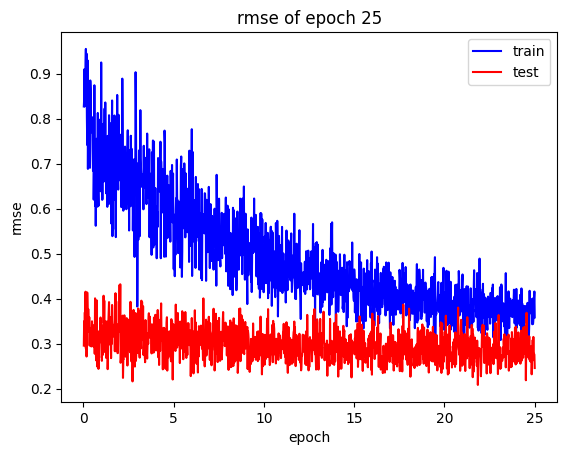

In [5]:
import animator
ani = animator.Animator()
num_epochs = 25
train_epoch_perc = []
train_loss = []
test_epoch_perc = []
test_loss = []
for epoch in range(num_epochs):
    # print(f"Epoch {epoch+1}\n-------------------------------")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for batch, rating_matrix in enumerate(train_iter):
        # Compute prediction and loss
        rating_matrix = rating_matrix.to(device).float()
        pred = model(rating_matrix)
        loss = loss_fn(pred, rating_matrix) #loss_fn(pred, r.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print("batch: {}, loss: {:.2f}".format(batch+1, loss.item()))
        train_epoch_perc.append((batch+1)/ len(train_iter) + epoch)
        train_loss.append(loss.item())

    
    with torch.no_grad():
        for batch, rating_matrix in enumerate(test_iter):
            rating_matrix = rating_matrix.to(device).float()
            pred = model(rating_matrix)
            loss = loss_fn(pred, rating_matrix)
            # print("RMSE: {:.2f}".format(loss.item()))
            test_epoch_perc.append((batch+1)/ len(test_iter) + epoch)
            test_loss.append(loss.item())

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='train')
    ani.ax.plot(test_epoch_perc,  test_loss,  color='r', label='test')
    ani.ax.set_xlabel('epoch')
    ani.ax.set_ylabel('rmse')
    ani.ax.legend()
    ani.ax.set_title(f'rmse of epoch {epoch+1}')
    ani.render()

ani.close()
# print("Done!")